<a href="https://colab.research.google.com/github/abdeslemlegdim/-Sign-Language-Recognition-System-SLRS--main/blob/main/amine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
import seaborn as sns
import random
import zipfile
import pathlib

from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import datetime
from tensorflow.keras.applications import  MobileNetV2, ResNet50V2
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix


In [ ]:
for dirpath,dirname,filename in os.walk("/content/drive/MyDrive/full_database/data"):
  print(f'There are {len(dirname)} directories and {len(filename)} images in {dirpath}')

There are 3 directories and 0 images in /content/drive/MyDrive/full_database/data
There are 6 directories and 0 images in /content/drive/MyDrive/full_database/data/train
There are 0 directories and 1380 images in /content/drive/MyDrive/full_database/data/train/call
There are 0 directories and 1380 images in /content/drive/MyDrive/full_database/data/train/mute
There are 0 directories and 1380 images in /content/drive/MyDrive/full_database/data/train/peace
There are 0 directories and 1380 images in /content/drive/MyDrive/full_database/data/train/ok
There are 0 directories and 1380 images in /content/drive/MyDrive/full_database/data/train/stop
There are 0 directories and 1380 images in /content/drive/MyDrive/full_database/data/train/palm
There are 6 directories and 0 images in /content/drive/MyDrive/full_database/data/test
There are 0 directories and 200 images in /content/drive/MyDrive/full_database/data/test/call
There are 0 directories and 200 images in /content/drive/MyDrive/full_data

In [ ]:
data_dir= pathlib.Path("/content/drive/MyDrive/full_database/data/train")
class_names = [i.name for i in data_dir.glob('*')]
class_names

['call', 'mute', 'peace', 'ok', 'stop', 'palm']

In [ ]:

def view_random_image(target_dir,target_class):
  #setup target directory
  target_folder = target_dir+"/"+target_class
  # print(target_folder)
  #get the random image from the target dir and targetclass
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image[0])

  #read the image and plot
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape:{img.shape}')

  return img

0acb5522-b03d-4b1b-87e3-dd46578e512c.jpg
Image shape:(1920, 1440, 3)


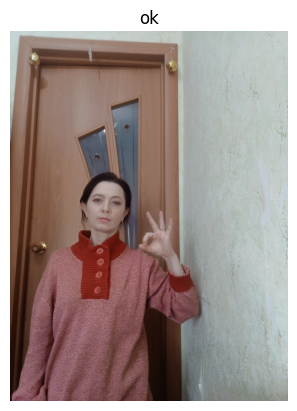

In [ ]:
img =view_random_image(target_dir="/content/drive/MyDrive/full_database/data/train",target_class='ok')

In [ ]:
Image_shape = (224, 224)
Batch_size = 128

train_dir = '/content/drive/MyDrive/full_database/data/train'
val_dir = '/content/drive/MyDrive/full_database/data/validation'

train_data_gen = ImageDataGenerator(rescale=1/255,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    brightness_range=[0.5, 1.5]
                                    )
val_data_gen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  brightness_range=[0.5, 1.5]
                                  )

train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size=Image_shape,
                                                batch_size=Batch_size,
                                                class_mode='categorical')

valid_data = val_data_gen.flow_from_directory(val_dir,
                                              target_size=Image_shape,
                                              batch_size=Batch_size,
                                              class_mode='categorical')


Found 8280 images belonging to 6 classes.
Found 2100 images belonging to 6 classes.


In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving tensorboardcallback:{log_dir}')
  return tensorboard_callback


10. Second Model where we have added a Dropout Layer to see the impact on the accuracy in comparison to our Baseline model we have created above.

  But able to notice that the accuracy decreased.

  We can do further more experiments to increase the accuracy via using **Data Augmenttaion** technique or by using other pre-trained model example **MobileNetV2**.

In [ ]:
base_model = ResNet50V2(include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)

x = Dense(512,activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(6,activation='softmax',name='output_layer')(x)

model_1=tf.keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
optimizer=Adam(learning_rate=0.001),
metrics=['accuracy'])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                    factor=0.5, patience=3)

history_transferlearning_1= model_1.fit(train_data,
epochs=5,
steps_per_epoch=len(train_data),
validation_data=valid_data,
validation_steps=int(0.25*len(valid_data)),
callbacks=[lr_scheduler,create_tensorboard_callback("transfer_learning",'transfer_learning_featureextraction2')])

94668760/94668760 [==============================] - 1s 0us/step
saving tensorboardcallback:transfer_learning/transfer_learning_featureextraction2/20230617-22
Epoch 1/5
65/65 [==============================] - 4077s 62s/step - loss: 0.7940 - accuracy: 0.6947 - val_loss: 2.8576 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 2/5
65/65 [==============================] - 3740s 57s/step - loss: 0.4783 - accuracy: 0.8336 - val_loss: 0.7674 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 3/5
65/65 [==============================] - 3747s 58s/step - loss: 0.3821 - accuracy: 0.8651 - val_loss: 0.5337 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 4/5
65/65 [==============================] - 3738s 57s/step - loss: 0.3025 - accuracy: 0.8920 - val_loss: 0.4002 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/5
65/65 [==============================] - 3702s 57s/step - loss: 0.2913 - accuracy: 0.8955 - val_loss: 0.3646 - val_accuracy: 0.8809 - lr: 0.0010


In [ ]:
base_model = ResNet50V2(include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3),name='input_layer')
x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=len(train_data) // 4,
                    validation_data=(valid_data),
                    validation_steps=len(valid_data) // 2)

model.save("model.h5")

Epoch 1/50
16/16 [==============================] - 1466s 90s/step - loss: 1.5922 - accuracy: 0.3369 - val_loss: 3.0648 - val_accuracy: 0.4980
Epoch 2/50
16/16 [==============================] - 1242s 77s/step - loss: 1.0323 - accuracy: 0.6196 - val_loss: 4.9626 - val_accuracy: 0.5547
Epoch 3/50
16/16 [==============================] - 1178s 73s/step - loss: 0.8062 - accuracy: 0.7002 - val_loss: 6.2637 - val_accuracy: 0.6777
Epoch 4/50
16/16 [==============================] - 1180s 73s/step - loss: 0.6551 - accuracy: 0.7627 - val_loss: 5.6429 - val_accuracy: 0.6680
Epoch 5/50
16/16 [==============================] - 1180s 74s/step - loss: 0.6265 - accuracy: 0.7754 - val_loss: 5.4378 - val_accuracy: 0.6523
Epoch 6/50
16/16 [==============================] - 1173s 74s/step - loss: 0.6309 - accuracy: 0.7842 - val_loss: 2.9612 - val_accuracy: 0.6270
Epoch 7/50
16/16 [==============================] - 1176s 74s/step - loss: 0.5272 - accuracy: 0.8091 - val_loss: 1.1570 - val_accuracy: 0.7900

In [ ]:
base_model = ResNet50V2(include_top=False)
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3),name='input_layer')
x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data) // 8,
                    validation_data=(valid_data),
                    validation_steps=len(valid_data) // 4)

model.save("model.h5")

In [ ]:
base_model = MobileNetV2(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)

x = Dense(512,activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(6,activation='softmax',name='output_layer')(x)

model_0=tf.keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
optimizer=Adam(learning_rate=0.001),
metrics=['accuracy'])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                    factor=0.5, patience=3)


history_transferlearning_0= model_0.fit(train_data,
                                        epochs=12,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(1*len(valid_data)),
                                        callbacks=[lr_scheduler,create_tensorboard_callback("transfer_learning",'transfer_learning_featureextraction2')])

saving tensorboardcallback:transfer_learning/transfer_learning_featureextraction2/20230606-23
Epoch 1/12
65/65 [==============================] - 2038s 31s/step - loss: 0.7771 - accuracy: 0.7033 - val_loss: 6.4969 - val_accuracy: 0.3624 - lr: 0.0010
Epoch 2/12
65/65 [==============================] - 1912s 29s/step - loss: 0.3838 - accuracy: 0.8635 - val_loss: 2.6629 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 3/12
65/65 [==============================] - 1938s 30s/step - loss: 0.2932 - accuracy: 0.8953 - val_loss: 1.7679 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 4/12
65/65 [==============================] - 1931s 30s/step - loss: 0.2611 - accuracy: 0.9095 - val_loss: 2.7960 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 5/12
65/65 [==============================] - 1934s 30s/step - loss: 0.2138 - accuracy: 0.9268 - val_loss: 2.5362 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 6/12
65/65 [==============================] - 1935s 30s/step - loss: 0.2164 - accuracy: 0.9245 - val_loss: 4.4831 - val_

In [ ]:
model_1.save("/content/drive/MyDrive/Colab Notebooks/Dossier sans titre/final model/model.h5")

11. **Visualization** Plotting the Loss and Accuracy on Training and Validation data.

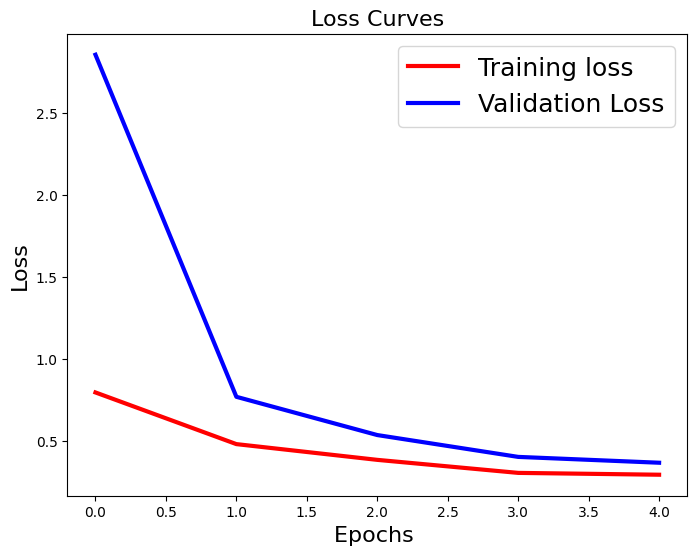

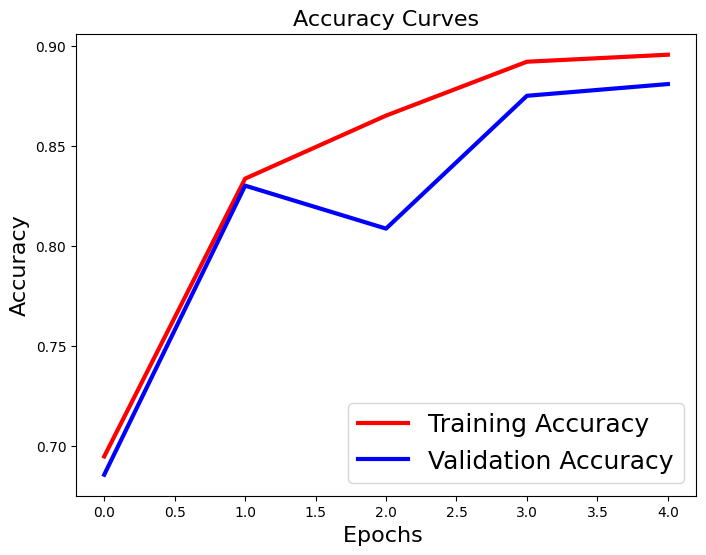

In [ ]:
#Plot the Graph
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_transferlearning_1.history['loss'],'r',linewidth=3.0)
plt.plot(history_transferlearning_1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.savefig('/content/drive/MyDrive/full_database/loss.jpg')

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_transferlearning_1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_transferlearning_1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.savefig('/content/drive/MyDrive/full_database/Accuracy.jpg')


In [ ]:
# find indices of train_data
train_data.class_indices

{'call': 0, 'mute': 1, 'ok': 2, 'palm': 3, 'peace': 4, 'stop': 5}

12. To look for **Predictions** on image from the model.

*Below code can be converted to function, so we can utilize the function again and again without writing the whole code

In [ ]:

category = {
    0:'call',
    1:'mute',
    2:'ok',
    3:'palm',
    4:'peace',
    5:'stop'
}

img_=image.load_img('/content/drive/MyDrive/full_database/data/validation/mute/fe0731b5-c221-44b3-81d5-16f338eb0ba6.jpg',target_size=(224,224))
img_array = image.img_to_array(img_)
print(img_array)
img_processed = np.expand_dims(img_array,axis=0)
img_processed 1./= 255
prediction = model.predict(img_processed)
print(prediction)
index = np.argmax(prediction)
print(index)
plt.title("Prediction - {}".format(category[index]))
plt.imshow(img_array)




SyntaxError: ignored

13. **Evaluation Metrics** Let's find the other metrics values and those are:-

* Precision
* Recall
* F1 score

this we'll find with the help of **classification report** and also try to find the **confusion matrix** for all the classes.

In [ ]:
len(os.listdir('/content/drive/MyDrive/full_database/data/test/call'))

200

In [ ]:
filedir = '/content/drive/MyDrive/full_database/data/test/call'

In [ ]:
filedir.split('/')[-1]

'call'

14. Function to define the accuracy for each class by doing preprocessing of the images in the test data. So all images in the test data converted to tensors having the exact input shape that we have provided to the images trained in the model.

In [ ]:
category = {
    0: 'call',
    1: 'mute',
    2: 'ok',
    3: 'palm',
    4: 'peace',
    5: 'stop'
}

In [ ]:
def predict_dir(filedir,model):
  cols=3
  pos=0
  images=[]
  total_images=len(os.listdir(filedir))
  rows=(total_images//cols+1)
  true = filedir.split('/')[-1]

  for i in sorted(os.listdir(filedir)):
    images.append(os.path.join(filedir,i))

  for subplot,imgg in enumerate(images):
    img_ = image.load_img(imgg,target_size=(224,224))
    img_array = image.img_to_array(img_)

    img_processed = np.expand_dims(img_array,axis=0)
    img_processed /= 255

    prediction = model_1.predict(img_processed)
    index = np.argmax(prediction)

    pred = category.get(index)
    if pred==true:
      pos+=1
  accu = pos/total_images
  print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(accu,pos=pos,total=total_images,orignal=true))

15. **Accuracy** for each calss in the test directory. How many of the images have been correctly classified

In [ ]:
for i in os.listdir('/content/drive/MyDrive/full_database/data/test'):
  # print(i)
  predict_dir(os.path.join('/content/drive/MyDrive/full_database/data/test',i),model_1)

1/1 [==============================] - 0s 185ms/step
Accuracy for call: 0.94 (189/200)
1/1 [==============================] - 0s 188ms/step
Accuracy for mute: 0.97 (195/200)
1/1 [==============================] - 0s 317ms/step
Accuracy for peace: 0.83 (166/200)
1/1 [==============================] - 0s 184ms/step
Accuracy for stop: 0.89 (177/200)
1/1 [==============================] - 0s 185ms/step
Accuracy for palm: 0.89 (177/200)
1/1 [==============================] - 0s 174ms/step
Accuracy for ok: 0.74 (148/200)


16. Check the accuracy for each label in the test dataset using **confusion_matrix** heat map **Visualization**

In [ ]:
from tensorflow.keras.preprocessing import image

def labels_confusion_matix(folder):
  mapping ={}
  for i,j in enumerate(sorted(os.listdir(folder))):
    # print(i)
    # print(j)

    mapping[j]=i
  files=[]
  real=[]
  predicted=[]

  for i in os.listdir(folder):
    true = os.path.join(folder,i)
    true = true.split('/')[-1]
    # print(true)
    true = (mapping[true])

    for j in os.listdir(os.path.join(folder,i)):
      img_ = image.load_img(os.path.join(folder,i,j), target_size=(224,224))
      img_array = image.img_to_array(img_)

      img_processed = np.expand_dims(img_array,axis=0)
      img_processed /=255

      prediction = model_1.predict(img_processed)

      index = np.argmax(prediction)

      predicted.append(index)
      real.append(true)
  return real,predicted





In [ ]:

def print_confusion_matrix(real,predicted):
  total_output_labels=6
  cmap='turbo'

  cm_plot_labels=[i for i in range(6)]

  cm = confusion_matrix(y_true=real,y_pred=predicted)

  df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)

  sns.set(font_scale=1.2)

  plt.figure(figsize=(5,5))

  s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap)

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('confusion_matrix.png')
  plt.show()






In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

category_mapping = {
    0: 'call',
    1: 'mute',
    2: 'ok',
    3: 'palm',
    4: 'peace',
    5: 'stop'
}

def print_confusion_matrix(real, predicted):
    total_output_labels = 6
    cmap = 'turbo'

    cm_plot_labels = [i for i in range(total_output_labels)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)

    df_cm = pd.DataFrame(cm, cm_plot_labels, cm_plot_labels)

    sns.set(font_scale=1.2)

    plt.figure(figsize=(6, 6))

    s = sns.heatmap(df_cm, fmt="d", annot=True, cmap=cmap)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()


NameError: ignored

1/1 [==============================] - 0s 336ms/step


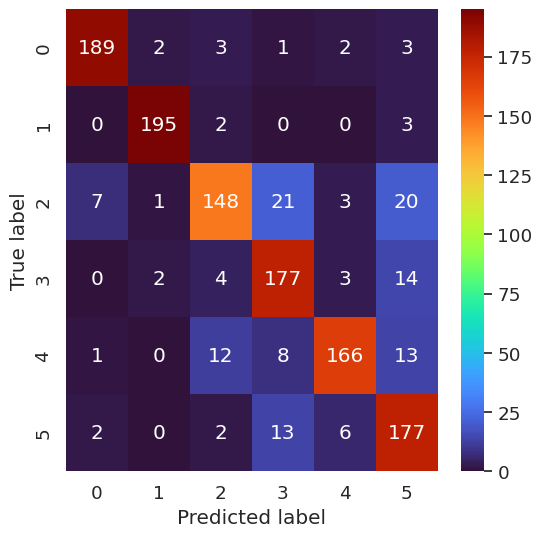

In [ ]:
y_true,y_pred=labels_confusion_matix('/content/drive/MyDrive/full_database/data/test')
print_confusion_matrix(y_true,y_pred)

Found 1200 images belonging to 6 classes.
38/38 [==============================] - 283s 7s/step


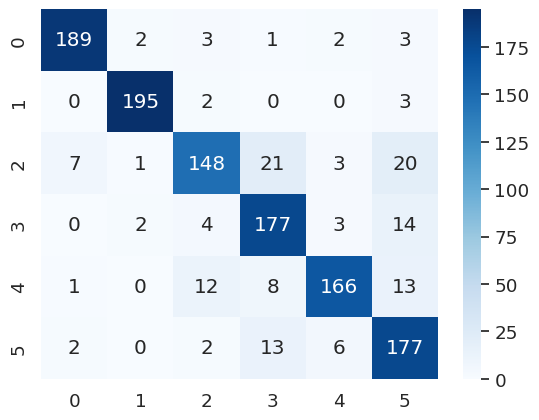

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

def labels_confusion_matix(test_dir):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

    test_data.reset()
    y_pred = model_1.predict(test_data)
    y_true = test_data.classes
    classes = np.unique(y_true)

    return y_true, np.argmax(y_pred, axis=1), classes

def print_confusion_matrix(real, predicted, classes):
    cm = confusion_matrix(real, predicted, labels=classes)
    cm_plot_labels = classes

    df_cm = pd.DataFrame(cm, cm_plot_labels, cm_plot_labels)

    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.show()

y_true, y_pred, classes = labels_confusion_matix('/content/drive/MyDrive/full_database/data/test')
print_confusion_matrix(y_true, y_pred, classes)


In [ ]:
test_dir = '/content/drive/MyDrive/full_database/data/test'
def labels_confusion_matrix(test_data_generator):
    y_true = test_data_generator.classes
    y_pred = model_1.predict(test_data_generator)
    classes = list(test_data_generator.class_indices.keys())

    return y_true, np.argmax(y_pred, axis=1), classes

def print_confusion_matrix(real, predicted, classes):
    cm = confusion_matrix(real, predicted, labels=classes)
    cm_plot_labels = classes

    df_cm = pd.DataFrame(cm, index=cm_plot_labels, columns=cm_plot_labels)

    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

y_true, y_pred, classes = labels_confusion_matrix(test_data_generator)
print_confusion_matrix(y_true, y_pred, classes)


Found 1200 images belonging to 6 classes.
38/38 [==============================] - 293s 8s/step


ValueError: ignored

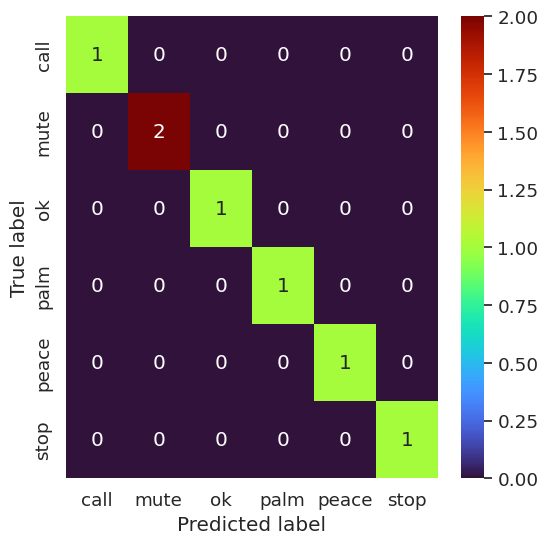

              precision    recall  f1-score   support

        call       1.00      1.00      1.00         1
        mute       1.00      1.00      1.00         2
          ok       1.00      1.00      1.00         1
        palm       1.00      1.00      1.00         1
       peace       1.00      1.00      1.00         1
        stop       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [ ]:
 import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

def labels_confusion_matrix(folder, model_1):
    mapping = {}
    for i, j in enumerate(sorted(os.listdir(folder))):
        mapping[j] = i

    real = []
    predicted = []

    for i in os.listdir(folder):
        true = os.path.join(folder, i)
        true = true.split('/')[-1]
        true = mapping[true]

        for j in os.listdir(os.path.join(folder, i)):
            img_ = image.load_img(os.path.join(folder, i, j), target_size=(224, 224))
            img_array = image.img_to_array(img_)

            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255

            prediction = model.predict(img_processed)

            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return real, predicted


category_mapping = {
    0: 'call',
    1: 'mute',
    2: 'ok',
    3: 'palm',
    4: 'peace',
    5: 'stop'
}

def print_confusion_matrix(real, predicted):
    total_output_labels = len(category_mapping)
    cmap = 'turbo'

    cm_plot_labels = [category_mapping[i] for i in range(total_output_labels)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)

    df_cm = pd.DataFrame(cm, cm_plot_labels, cm_plot_labels)

    sns.set(font_scale=1.2)

    plt.figure(figsize=(6, 6))

    s = sns.heatmap(df_cm, fmt="d", annot=True, cmap=cmap)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()


print_confusion_matrix(y_true, y_pred)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_true, y_pred, target_names=category_mapping.values())
print(classification_rep)